## TorchVision Object Detection

Adapted by Laurentius von Liechti from this tutorial: 
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [14]:
import os

os.environ["KERAS_BACKEND"] = "torch"  # @param ["tensorflow", "jax", "torch"]

import os
import re
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import tensorflow_datasets as tfds
import tensorflow as tf
from torch.utils.data import Dataset
from torchvision import tv_tensors
from torchvision.io import read_image
from torchvision.transforms import v2 as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from utils.engine import train_one_epoch, evaluate
import utils.utils as utils


### Utils

Fetch these into the utils folder if they aren't already present.

* os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
* os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
* os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
* os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
* os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

In [15]:
train_image_dir = "../data/train/images/"
train_label_dir = "../data/train/labels/"
val_image_dir = "../data/valid/images/"
val_label_dir = "../data/valid/labels/"

label_array = ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']

In [16]:
"""
Group3DataSet class for loading images and labels

__init__ - initializes the class with image and label directories
__len__ - returns the number of images
__getitem__ - returns the image and label at the given index
get_pic - returns the image at the given path
get_target - returns the target at the given path
load - loads the images and labels from the directories

Parameters:
    image_dir - the directory containing the images
    label_dir - the directory containing the labels
"""
class Group3Dataset(Dataset):
    IMG_SIZE = 416
    images = []
    targets = []

    """
    Initializes the class with image and label directories

    Parameters:
        image_dir - the directory containing the images
        label_dir - the directory containing the labels
    """
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.load(image_dir, label_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        target = self.targets[idx]
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    """
    Returns the image at the given path

    Parameters:
        img_path - the path to the image

    Returns:
        dimg - the image tensor
    """
    def get_pic(self, img_path):
        img = read_image(img_path)
        tvimg = tv_tensors.Image(img)
        dimg = torchvision.transforms.v2.functional.to_dtype(tvimg, torch.float32, scale=True)
        return dimg

    """
    Returns the target at the given label_path for the given img_path

    Converts the [x/y]center/width/height label to a tensor and 
    calculates the bounding box coordinates for each label in the label file

    It returns a dictionary containing the boxes, labels, image_id, area, 
    and iscrowd expected by the FasterRCNN model

    Parameters:
        img_path - the path to the image
        label_path - the path to the label

    Returns:
        dict - a target dictionary
    """
    def get_target(self, img_path, label_path):
        rows = open(label_path).read().strip().split("\n")
        boxes = []
        labels = []
        areas = []
        for row in rows:
            label, x_center, y_center, width, height = re.split(r'\s+', row)
            x_start = int((float(x_center) - float(width)/2)*self.IMG_SIZE)
            y_start = int((float(y_center) - float(height)/2)*self.IMG_SIZE)
            x_end = int((float(x_center) + float(width)/2)*self.IMG_SIZE)
            y_end = int((float(y_center) + float(height)/2)*self.IMG_SIZE)
            boxes.append([x_start, y_start, x_end, y_end])
            labels.append(int(label) + 1) # 0 is reserved for background
            areas.append((x_end - x_start) * (y_end - y_start))
        return {
            'boxes': tv_tensors.BoundingBoxes(
                boxes,
                format=tv_tensors.BoundingBoxFormat.XYXY, 
                canvas_size=(self.IMG_SIZE, self.IMG_SIZE)), 
            'labels': torch.tensor(labels, dtype=torch.int64), 
            'image_id': img_path,
            'area': torch.Tensor(areas),
            'iscrowd': torch.zeros((len(labels),), dtype=torch.int64)
            }

    def load(self, image_dir, label_dir):
        image_files = os.listdir(image_dir)
        label_files = os.listdir(label_dir)
        image_files.sort()
        label_files.sort()
        self.images = []
        self.targets = []
        
        for i, img_file in enumerate(image_files):
            image_path = image_dir + img_file
            label_path = label_dir + label_files[i]
            self.images.append(self.get_pic(image_path))
            self.targets.append(self.get_target(image_path, label_path))
            
        return self.images, self.targets

In [17]:
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

### Test the custom dataset

* Use a small batch size and simple model to test our custom dataset to ensure it has all the required data structures in the right format for training and testing, end-to-end

In [18]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

train_ds = Group3Dataset(train_image_dir, train_label_dir, get_transform(train=True))

data_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(0.4265, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1069, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0052, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0092, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


## Train and Evaluate FasterRCNN

In [19]:
# Leaving out MPS because of the float32 limitation
# if torch.backends.mps.is_available():
#     device = torch.device("mps")
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Device: {device}")

# our dataset has two classes only - background and person
num_classes = 6
# use our dataset and defined transformations
dataset = Group3Dataset(train_image_dir, train_label_dir, get_transform(train=True))
dataset_test = Group3Dataset(val_image_dir, val_label_dir, get_transform(train=False))

# Skip this because we already have a train/test split for consistent model comparison
# split the dataset in train and test set
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = len(label_array) + 1  # # classes + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 1

evaluators = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    eval = evaluate(model, data_loader_test, device=device)
    evaluators.append(eval)

torch.save(model.state_dict(), "model_factrcnn.pth")

Device: cpu
Epoch: [0]  [  0/439]  eta: 0:17:43  lr: 0.000016  loss: 2.2320 (2.2320)  loss_classifier: 1.9939 (1.9939)  loss_box_reg: 0.1977 (0.1977)  loss_objectness: 0.0387 (0.0387)  loss_rpn_box_reg: 0.0017 (0.0017)  time: 2.4221  data: 0.0003
Epoch: [0]  [ 10/439]  eta: 0:16:32  lr: 0.000130  loss: 2.0842 (2.0559)  loss_classifier: 1.8430 (1.7580)  loss_box_reg: 0.1977 (0.2584)  loss_objectness: 0.0236 (0.0303)  loss_rpn_box_reg: 0.0036 (0.0091)  time: 2.3131  data: 0.0005
Epoch: [0]  [ 20/439]  eta: 0:15:59  lr: 0.000244  loss: 1.6199 (1.5703)  loss_classifier: 1.2451 (1.2578)  loss_box_reg: 0.2048 (0.2766)  loss_objectness: 0.0200 (0.0281)  loss_rpn_box_reg: 0.0036 (0.0079)  time: 2.2830  data: 0.0005
Epoch: [0]  [ 30/439]  eta: 0:15:34  lr: 0.000359  loss: 0.6374 (1.2241)  loss_classifier: 0.3174 (0.9328)  loss_box_reg: 0.2276 (0.2588)  loss_objectness: 0.0194 (0.0255)  loss_rpn_box_reg: 0.0054 (0.0069)  time: 2.2711  data: 0.0005
Epoch: [0]  [ 40/439]  eta: 0:15:12  lr: 0.00047

In [20]:
eval = evaluate(model, data_loader_test, device=device)

creating index...
index created!
Test:  [  0/250]  eta: 0:02:37  model_time: 0.6249 (0.6249)  evaluator_time: 0.0026 (0.0026)  time: 0.6281  data: 0.0005
Test:  [100/250]  eta: 0:01:29  model_time: 0.5936 (0.5949)  evaluator_time: 0.0005 (0.0007)  time: 0.5953  data: 0.0001
Test:  [200/250]  eta: 0:00:29  model_time: 0.5812 (0.5946)  evaluator_time: 0.0006 (0.0007)  time: 0.5837  data: 0.0001
Test:  [249/250]  eta: 0:00:00  model_time: 0.5833 (0.5935)  evaluator_time: 0.0006 (0.0007)  time: 0.5845  data: 0.0001
Test: Total time: 0:02:28 (0.5943 s / it)
Averaged stats: model_time: 0.5833 (0.5935)  evaluator_time: 0.0006 (0.0007)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.551
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.370
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small 

In [39]:
def multiclass_summarize( ce, ap=1, iouThr=None, areaRng='all', maxDets=100 ):
    p = ce.params
    print(p.iouThrs)
    iStr = ' {:<18} {} @[ IoU={:<9} | area={:>6s} | maxDets={:>3d} ] = {:0.3f}'
    titleStr = 'Average Precision' if ap == 1 else 'Average Recall'
    typeStr = '(AP)' if ap==1 else '(AR)'
    iouStr = '{:0.2f}:{:0.2f}'.format(p.iouThrs[0], p.iouThrs[-1]) \
        if iouThr is None else '{:0.2f}'.format(iouThr)

    aind = [i for i, aRng in enumerate(p.areaRngLbl) if aRng == areaRng]
    mind = [i for i, mDet in enumerate(p.maxDets) if mDet == maxDets]
    if ap == 1:
        # dimension of precision: [TxRxKxAxM]
        s = ce.eval['precision']
        # IoU
        if iouThr is not None:
            t = np.where(iouThr == p.iouThrs)[0]
            s = s[t]
        s = s[:,:,:,aind,mind]
    else:
        # dimension of recall: [TxKxAxM]
        s = ce.eval['recall']
        if iouThr is not None:
            t = np.where(iouThr == p.iouThrs)[0]
            s = s[t]
        s = s[:,:,aind,mind]
    metrics = [-1]
    if len(s[s>-1]) != 0:
        mean_s = np.mean(s[s>-1])
        num_classes = len(p.catIds)
        metrics = np.zeros((num_classes+1,))
        avg = 0.0
        label = 'AP' if ap == 1 else 'AR'
        for i in range(0, num_classes):
            mu = np.mean(s[:,:,i,:]) if ap == 1 else np.mean(s[:,i,:])
            print('class {0} {1} : {2}'.format(i,label,mu))
            metrics[i] = mu
            avg +=mu
        mu = avg / num_classes
        metrics[num_classes] = mu
        print('(all) m{0} : {1}'.format(label, mu))
    print(iStr.format(titleStr, typeStr, iouStr, areaRng, maxDets, mean_s))
    return metrics

iou_type = "bbox"
ce = eval.coco_eval[iou_type]
ap50 = multiclass_summarize(ce, ap=1, iouThr=0.5) # Print AP for each class
ap = multiclass_summarize(ce) # Print AP for each class
ar = multiclass_summarize(ce, ap=2) # Print AR for each class

# summarize the results
import pandas as pd
dfMetrics = pd.DataFrame({
    "class": label_array + ['all'],
    "ap": ap,
    "ap50": ap50,
    "r": ar,
    "p": ap,
})
display(dfMetrics)

[0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
class 0 AP : 0.6691170078730871
class 1 AP : 0.6807712099776464
class 2 AP : 0.39838980144066183
class 3 AP : 0.7100248955312386
class 4 AP : 0.2971397381800174
(all) mAP : 0.5510885306005303
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.551
[0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
class 0 AP : 0.47462342091759946
class 1 AP : 0.35715840629281875
class 2 AP : 0.20780115112818254
class 3 AP : 0.4084303018104592
class 4 AP : 0.19355458969180267
(all) mAP : 0.3283135739681725
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.328
[0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
class 0 AR : 0.70625
class 1 AR : 0.5478260869565217
class 2 AR : 0.5042016806722689
class 3 AR : 0.6000000000000001
class 4 AR : 0.4066666666666666
(all) mAR : 0.5529888868590915
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.553


,class,ap,ap50,r,p
0,Ambulance,0.474623,0.669117,0.706250,0.474623
1,Bus,0.357158,0.680771,0.547826,0.357158
2,Car,0.207801,0.398390,0.504202,0.207801
3,Motorcycle,0.408430,0.710025,0.600000,0.408430
4,Truck,0.193555,0.297140,0.406667,0.193555
5,all,0.328314,0.551089,0.552989,0.328314


In [40]:
metrics_file_name = "../results/model_fastrcnn_metrics.pkl"
dfMetrics.to_pickle(metrics_file_name)

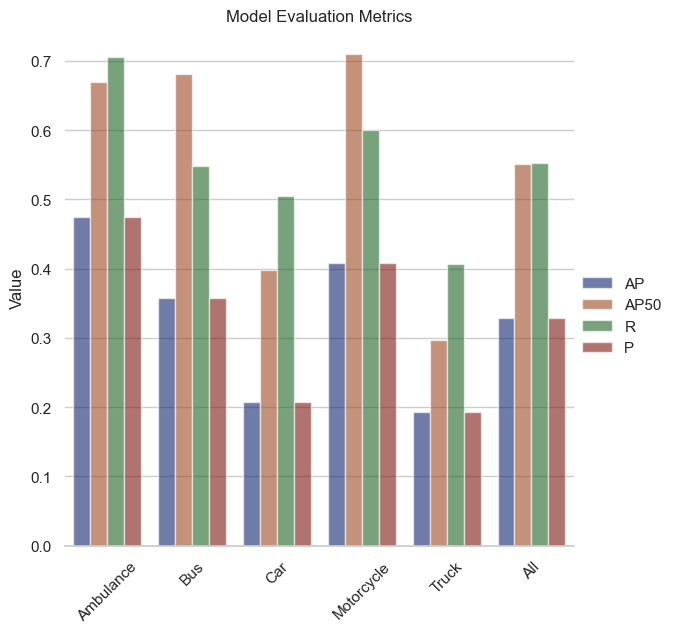

In [45]:
# Use seaborn to plot the ap and r for each class
import seaborn as sns
import matplotlib.pyplot as plt

dfMetrics = pd.read_pickle(metrics_file_name)
dfMetrics = dfMetrics.melt(id_vars="class", var_name="metric", value_name="value")
dfMetrics["metric"] = dfMetrics["metric"].apply(lambda x: x.upper())
dfMetrics["class"] = dfMetrics["class"].apply(lambda x: x.capitalize())
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=dfMetrics, kind="bar",
    x="class", y="value", hue="metric",
    palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Value")
g.legend.set_title("")
plt.title("Model Evaluation Metrics")
plt.xticks(rotation=45)
plt.show()


## Detecto version of fastrcnn

In [50]:
dmodel = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = len(label_array) + 1  # # classes + background
# get number of input features for the classifier
in_features = dmodel.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
dmodel.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
dmodel.load_state_dict(torch.load("detecto_fastrcnn.pth"))

<All keys matched successfully>

In [62]:
# Adapt dataset to match detecto's dataset
from torchvision.transforms import v2 as transforms
tv_normalize_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
detecto_transforms = transforms.Compose([transforms.ToTensor(), tv_normalize_transform])

d_dataset_test = Group3Dataset(val_image_dir, val_label_dir, detecto_transforms)
d_data_loader_test = torch.utils.data.DataLoader(
    d_dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

deval = evaluate(dmodel, d_data_loader_test, device=device)

/Users/kai/anaconda3/envs/py312/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


creating index...
index created!
Test:  [  0/250]  eta: 0:02:45  model_time: 0.6603 (0.6603)  evaluator_time: 0.0010 (0.0010)  time: 0.6622  data: 0.0009
Test:  [100/250]  eta: 0:01:31  model_time: 0.6004 (0.6075)  evaluator_time: 0.0004 (0.0005)  time: 0.6027  data: 0.0008
Test:  [200/250]  eta: 0:00:30  model_time: 0.6015 (0.6055)  evaluator_time: 0.0005 (0.0005)  time: 0.6042  data: 0.0008
Test:  [249/250]  eta: 0:00:00  model_time: 0.6050 (0.6058)  evaluator_time: 0.0004 (0.0005)  time: 0.6060  data: 0.0009
Test: Total time: 0:02:31 (0.6072 s / it)
Averaged stats: model_time: 0.6050 (0.6058)  evaluator_time: 0.0004 (0.0005)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.408
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.605
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.486
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small 

In [63]:
iou_type = "bbox"
d_ce = deval.coco_eval[iou_type]
d_ap50 = multiclass_summarize(d_ce, ap=1, iouThr=0.5) # Print AP for each class
d_ap = multiclass_summarize(d_ce) # Print AP for each class
d_ar = multiclass_summarize(d_ce, ap=2) # Print AR for each class

# summarize the results
import pandas as pd
d_dfMetrics = pd.DataFrame({
    "class": label_array + ['all'],
    "ap": d_ap,
    "ap50": d_ap50,
    "r": d_ar,
    "p": d_ap,
})
display(d_dfMetrics)

[0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
class 0 AP : 0.8069112831535645
class 1 AP : 0.6956345634563456
class 2 AP : 0.42233042767307416
class 3 AP : 0.6976531856149923
class 4 AP : 0.40161675301234
(all) mAP : 0.6048292425820634
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.605
[0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
class 0 AP : 0.6551839242439391
class 1 AP : 0.46336715814438584
class 2 AP : 0.26675936516891485
class 3 AP : 0.4212161335002456
class 4 AP : 0.23471768063501103
(all) mAP : 0.4082488523384993
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.408
[0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
class 0 AR : 0.74375
class 1 AR : 0.5782608695652175
class 2 AR : 0.419327731092437
class 3 AR : 0.5739130434782609
class 4 AR : 0.52
(all) mAR : 0.5670503288271831
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.567


,class,ap,ap50,r,p
0,Ambulance,0.655184,0.806911,0.743750,0.655184
1,Bus,0.463367,0.695635,0.578261,0.463367
2,Car,0.266759,0.422330,0.419328,0.266759
3,Motorcycle,0.421216,0.697653,0.573913,0.421216
4,Truck,0.234718,0.401617,0.520000,0.234718
5,all,0.408249,0.604829,0.567050,0.408249


In [64]:
metrics_file_name = "../results/model_detecto_metrics.pkl"
d_dfMetrics.to_pickle(metrics_file_name)

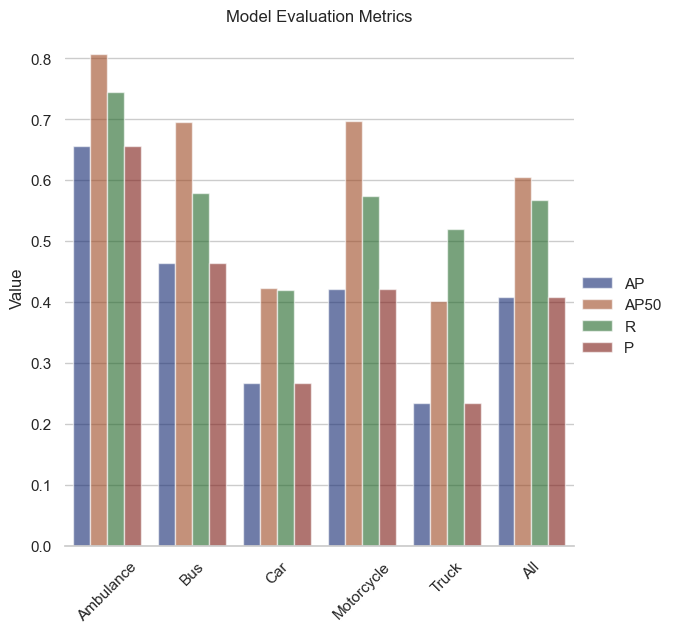

In [65]:
# Use seaborn to plot the ap and r for each class
import seaborn as sns
import matplotlib.pyplot as plt

metrics_file_name = "../results/model_detecto_metrics.pkl"
d_dfMetrics = pd.read_pickle(metrics_file_name)
d_dfMetrics = d_dfMetrics.melt(id_vars="class", var_name="metric", value_name="value")
d_dfMetrics["metric"] = d_dfMetrics["metric"].apply(lambda x: x.upper())
d_dfMetrics["class"] = d_dfMetrics["class"].apply(lambda x: x.capitalize())
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=d_dfMetrics, kind="bar",
    x="class", y="value", hue="metric",
    palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Value")
g.legend.set_title("")
plt.title("Model Evaluation Metrics")
plt.xticks(rotation=45)
plt.show()
